## load training triples

In [1]:
import json
import numpy as np

with open('training_data_pairs_shuffled.json', 'r') as f:
    loaded_data = json.load(f)

In [2]:
label_list = []
anchor_list = []
game_list = []

for entry in loaded_data:
    label_list.append(entry['label'])
    anchor_list.append(f"{entry['anchor']['id']} {entry['anchor']['features']} {entry['anchor']['description']}")
    game_list.append(f"{entry['game']['id']} {entry['game']['features']} {entry['game']['description']}")

In [3]:
print(np.array(anchor_list[0]))

1 Adventure Shooter Simulator Action Fantasy Stealth actionadventure blackjack bowandarrow crime darkness death difficultylevel ghosts immersive invisibility melee movingbodies pacifistplaythrough particlesystem pickpocketing polygonald potion realtimecombat shadowstealth singleplayeronly stealthkill steampunk swimming swordplay theft thief ultimate thief back tread softly make complex full loot steal outsmart enemy riveting story draw world thief metal place powerful fanatical corruption life thief however fence early mission local sheriff hunting take hear prophecy metal leaves hired kill letter eavesdrop mechanist meeting father conversion street people mindless wear emit vapor capable reducing nearby rust provide twenty servant project realizing recording blackmail recording safe deposit order coerce revealing estate evidence crime scene police officer deliver suspicious letter carried portal wounded pagan portal outside city pagan trail blood join lead office learn project inadver

In [4]:
print(game_list[0])

2 Adventure Simulator Action Fantasy Stealth actionadventure assassin basketball betrayal blackjack bowandarrow bread crime darkness difficultylevel ghosts immersive instantkill invisibility magic maleprotagonist medieval melee movingbodies murder pacifistplaythrough particlesystem pickpocketing plottwist polygonald potion realtimecombat reluctanthero retailgameswithsteamactivation shadowstealth singleplayeronly stealthkill steampunk swimming swordplay theft thief tombraiding voiceacting thief stealth dark sneak subterranean forbidding dark sinister city heavily inspired dark ally money hidden allies story deception revenge


In [5]:
# import polars as pl
#
# label_list = []
# anchor_id_list = []
# anchor_features_list = []
# anchor_description_list = []
# game_id_list = []
# game_features_list = []
# game_description_list = []
# 
# for entry in loaded_data:
#     label_list.append(entry['label'])
#     anchor_id_list.append(entry['anchor']['id'])
#     anchor_features_list.append(entry['anchor']['features'])
#     anchor_description_list.append(entry['anchor']['description'])
#     game_id_list.append(entry['game']['id'])
#     game_features_list.append(entry['game']['features'])
#     game_description_list.append(entry['game']['description'])
# 
# data = {
#     'label': label_list,
#     'anchor_id': anchor_id_list,
#     'anchor_features': anchor_features_list,
#     'anchor_description': anchor_description_list,
#     'game_id': game_id_list,
#     'game_features': game_features_list,
#     'game_description': game_description_list
# }
# 
# df = pl.DataFrame(data)
# df.head()

In [6]:
# all_pairs_count = df.count().item(0,0)
# print(all_pairs_count)
# train_df = df.sample(all_pairs_count*0.8, shuffle=True, seed=24)
# print(train_df.describe())

In [7]:
# corpus = train_df.get_column('anchor_description') + train_df.get_column('game_description') + train_df.get_column('anchor_features') + train_df.get_column('game_features')
# print(corpus.shape)

In [8]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# 
# MAX_NUM_WORDS = 10000
# tokenizer = Tokenizer(MAX_NUM_WORDS)
# tokenizer.fit_on_texts(corpus)
# 
# A_train_description = tokenizer.texts_to_sequences(train_df.get_column('anchor_description'))
# B_train_description = tokenizer.texts_to_sequences(train_df.get_column('game_description'))
# 
# A_train_features = tokenizer.texts_to_sequences(train_df.get_column('anchor_features'))
# B_train_features = tokenizer.texts_to_sequences(train_df.get_column('game_features'))

In [9]:
# MAX_DESC_LENGTH = max([len(d) for d in A_train_description + B_train_description])
# MAX_FEAT_LENGTH = max([len(d) for d in A_train_features + B_train_features])
# print(f'MAX_DESC_LENGTH: {MAX_DESC_LENGTH} | MAX_FEAT_LENGTH: {MAX_FEAT_LENGTH}')

In [10]:
# A_train_description = pad_sequences(A_train_description, maxlen=MAX_DESC_LENGTH)
# B_train_description = pad_sequences(B_train_description, maxlen=MAX_DESC_LENGTH)
# 
# A_train_features = pad_sequences(A_train_features, maxlen=MAX_FEAT_LENGTH)
# B_train_features = pad_sequences(B_train_features, maxlen=MAX_FEAT_LENGTH)

In [11]:
# train_df.head()

In [12]:
# new_train_df = train_df.insert_column(1, pl.Series("A_description", A_train_description))
# new_train_df = new_train_df.insert_column(1, pl.Series("B_description", B_train_description))
# new_train_df = new_train_df.insert_column(1, pl.Series("A_features", A_train_features))
# new_train_df = new_train_df.insert_column(1, pl.Series("B_features", B_train_features))

In [13]:
# new_train_df = new_train_df.drop('anchor_features', 'anchor_description', 'game_features', 'game_description')
# new_train_df.head()

In [14]:
from sklearn.model_selection import train_test_split

train_anchor, temp_anchor, train_game, temp_game, train_labels, temp_labels = train_test_split(
    anchor_list,
    game_list,
    label_list,
    test_size=0.8, random_state=42)
val_anchor, test_anchor, val_game, test_game, val_labels, test_labels = train_test_split(
    temp_anchor,
    temp_game,
    temp_labels,
    test_size=0.5, random_state=42)

In [41]:
MAX_LENGTH = max([len(d) for d in anchor_list + game_list])
NUM_CLASSES = 1
MAX_TOKENS = 10000

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

anchor_input = tf.keras.Input(shape=(1,), name='anchor', dtype=tf.string)
game_input = tf.keras.Input(shape=(1,), name='game', dtype=tf.string)

vectorize_layer = layers.TextVectorization(max_tokens=MAX_TOKENS, output_mode='int') 
vectorize_layer.adapt(anchor_list)
A_vectorized = vectorize_layer(anchor_input)
B_vectorized = vectorize_layer(game_input)

embedding_layer = layers.Embedding(input_dim=MAX_TOKENS, output_dim=128)
A_embedded = embedding_layer(A_vectorized)
B_embedded = embedding_layer(B_vectorized)

shared_lstm = layers.LSTM(64)
A_lstm = shared_lstm(A_embedded)
B_lstm = shared_lstm(B_embedded)

dense1 = layers.Dense(
    units=64, 
    activation='relu')
A_dense = dense1(A_lstm)
B_dense = dense1(B_lstm)

dropout = layers.Dropout(0.5)
A_drop = dropout(A_dense)
B_drop = dropout(B_dense)

dense2 = layers.Dense(
    units=16, 
    activation='relu')
A_output = dense2(A_drop)
B_output = dense2(B_drop)

merged = layers.concatenate(
    [A_output, B_output], 
    axis=-1)

dense3 = layers.Dense(
    units=NUM_CLASSES, 
    activation='sigmoid')

predictions = dense3(merged)

siamese_model = models.Model(inputs=[anchor_input, game_input],
                                  outputs=predictions, 
                                  name='siamese_model')

#custom_adam = Adam(learning_rate=0.01)
siamese_model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 game (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_6 (Text  (None, None)                 0         ['anchor[0][0]',              
 Vectorization)                                                      'game[0][0]']                
                                                                                                  
 embedding_6 (Embedding)     (None, None, 128)            1280000   ['text_vectorizati

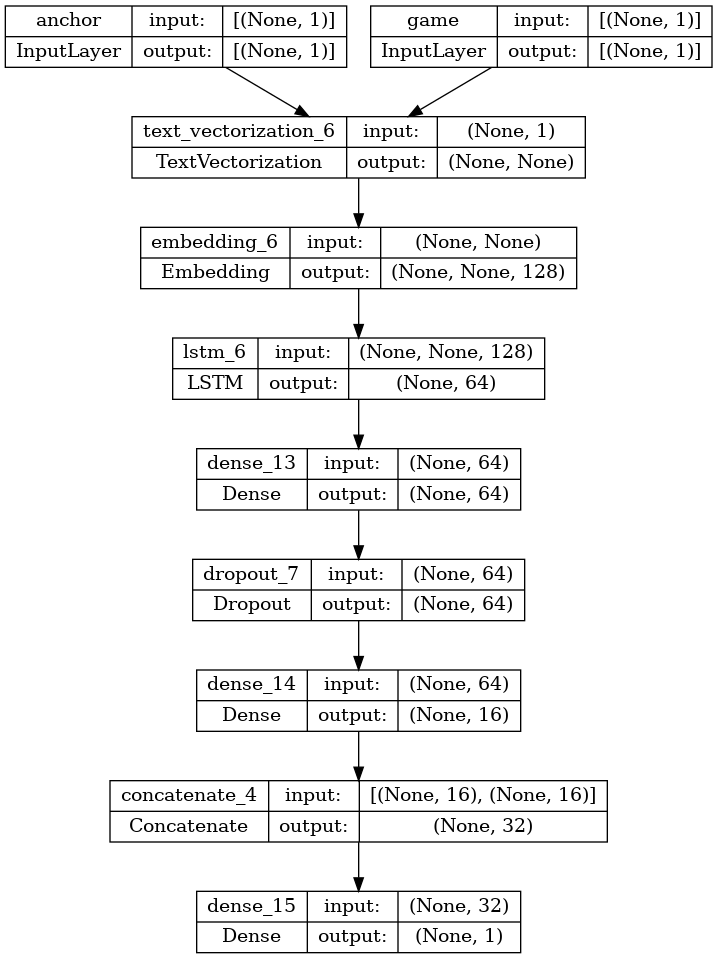

In [43]:
from keras.utils import plot_model

plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
history = siamese_model.fit(
    [np.array(train_anchor), np.array(train_game)],
    np.array(train_labels),
    epochs=15,
    batch_size=64,
    use_multiprocessing=True,
    workers=10,
    shuffle=True,
    validation_data=([np.array(val_anchor), np.array(val_game)], np.array(val_labels))
)

Epoch 1/15
876/876 [==============================] - 66s 72ms/step - loss: 0.6562 - accuracy: 0.6376 - val_loss: 0.6521 - val_accuracy: 0.6402
Epoch 2/15
876/876 [==============================] - 38s 44ms/step - loss: 0.6508 - accuracy: 0.6420 - val_loss: 0.6510 - val_accuracy: 0.6410
Epoch 3/15
876/876 [==============================] - 33s 37ms/step - loss: 0.6561 - accuracy: 0.6377 - val_loss: 0.6579 - val_accuracy: 0.6315
Epoch 4/15
876/876 [==============================] - 30s 35ms/step - loss: 0.6564 - accuracy: 0.6348 - val_loss: 0.6547 - val_accuracy: 0.6393
Epoch 5/15
876/876 [==============================] - 31s 35ms/step - loss: 0.5451 - accuracy: 0.7211 - val_loss: 0.3083 - val_accuracy: 0.8741
Epoch 6/15
876/876 [==============================] - 30s 35ms/step - loss: 0.2635 - accuracy: 0.8980 - val_loss: 0.2353 - val_accuracy: 0.9067
Epoch 7/15
876/876 [==============================] - 30s 34ms/step - loss: 0.2249 - accuracy: 0.9105 - val_loss: 0.2259 - val_accuracy:

In [45]:
siamese_model.save('siamese_model_v2.keras')

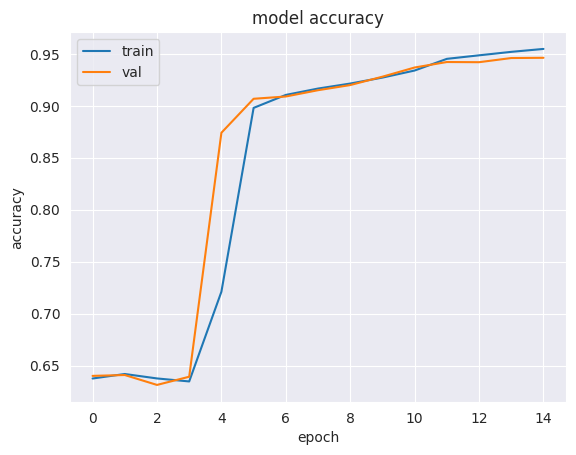

In [46]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

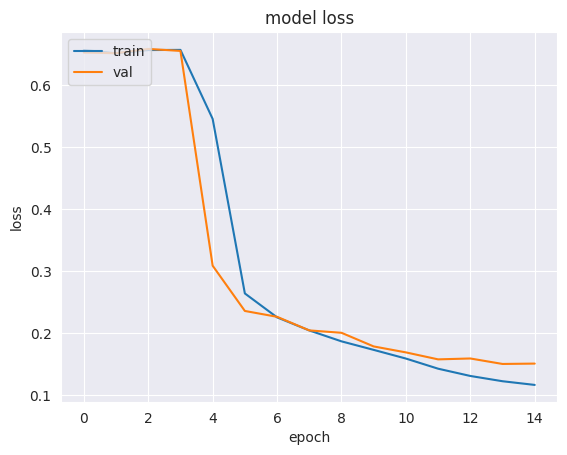

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
test_loss, test_accuracy = siamese_model.evaluate(
    (np.array(test_anchor), np.array(test_game)),
    np.array(test_labels),
)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

3502/3502 [==============================] - 21s 6ms/step - loss: 0.1487 - accuracy: 0.9463
Test Loss: 0.1487, Test Accuracy: 94.63%
